# State Farm (no data augmentation)

## Steps:

1. load train and validation data
2. load VGG model
3. remove final layer and precompute
4. replace final layer
5. train
6. test

In [87]:
%matplotlib inline

## 1. Load data

In [1]:
floydhub = False
sample = False

In [109]:
if floydhub:
    data_path = "/input/"
    bottleneck_path = "/output/bottlenecks/"
    results_path = "/output/results/"
else:
    data_path = "./data/dup/"
    if sample:
        data_path += "sample/"
    bottleneck_path = "./bottlenecks/"
    results_path = "./results/"
%mkdir $bottleneck_path
%mkdir $results_path

mkdir: cannot create directory ‘./bottlenecks/’: File exists
mkdir: cannot create directory ‘./results/’: File exists


In [110]:
batch_size = 64

In [111]:
from utils import get_data, get_classes, get_batches
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(featurewise_center=False, samplewise_center=False)

#train_data = get_data(data_path + "train", target_size=(299,299))
#valid_data = get_data(data_path + "valid", target_size=(299,299))
train_data = get_batches(data_path + "train", target_size=(299,299), shuffle=False, class_mode=None, batch_size=batch_size)
valid_data = get_batches(data_path + "valid", target_size=(299,299), shuffle=False, class_mode=None, batch_size=batch_size)

Found 21496 images belonging to 10 classes.
Found 2766 images belonging to 10 classes.


In [112]:
val_classes, train_classes, val_labels, train_labels, _,_,_ = get_classes(data_path)

Found 21496 images belonging to 10 classes.
Found 2766 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


## 2. Load Inception

In [113]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers.core import Flatten, Lambda, Dense, Dropout
from keras.layers import Input, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

input = Input(shape=(3, 299, 299))
preprocessor = Lambda(preprocess_input)
base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=preprocessor(input))
for l in base_model.layers: l.trainable=False

base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 299, 299)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [ ]:
#base_model.summary()

In [ ]:
#train_bottlenecks = base_model.predict(train_data, verbose=1)
train_bottlenecks = base_model.predict_generator(train_data, train_data.nb_sample)

In [ ]:
#valid_bottlenecks = base_model.predict(valid_data, verbose=1)
valid_bottlenecks = base_model.predict_generator(valid_data, valid_data.nb_sample)

In [ ]:
from utils import save_array
save_array(bottleneck_path+"inception_train_bottlenecks_dup.bc", train_bottlenecks)
save_array(bottleneck_path+"inception_valid_bottlenecks_dup.bc", valid_bottlenecks)

In [127]:
%ls $bottleneck_path

inception_train_bottlenecks.bc/      train_bottlenecks.bc/
inception_train_bottlenecks_dup.bc/  train_bottlenecks_new.bc/
inception_valid_bottlenecks.bc/      valid_bottlenecks.bc/
inception_valid_bottlenecks_dup.bc/  valid_bottlenecks_new.bc/


## 4. Train classification network

In [146]:
input = Input(shape=train_bottlenecks.shape[1:])
x = GlobalAveragePooling2D()(input)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(10, activation='softmax')(x)

fc_model = Model(input=input, output=x)
fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fc_model.summary()

In [147]:
from keras import backend as K

In [148]:
from keras.callbacks import ModelCheckpoint
cb = [ModelCheckpoint("inception-2x1024-{epoch:02d}-{val_loss:.3f}.hdf5", save_best_only=True)]

In [149]:
K.set_value(fc_model.optimizer.lr, 0.01)
fc_model.fit(train_bottlenecks, train_labels, nb_epoch=10, validation_data=(valid_bottlenecks, val_labels), batch_size=batch_size, verbose=2, callbacks=cb)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/lock_dir/lock


Train on 21496 samples, validate on 2766 samples
Epoch 1/10
9s - loss: 0.9005 - acc: 0.8079 - val_loss: 2.3372 - val_acc: 0.6873
Epoch 2/10
9s - loss: 0.2620 - acc: 0.9396 - val_loss: 1.8189 - val_acc: 0.7451
Epoch 3/10
9s - loss: 0.1718 - acc: 0.9599 - val_loss: 1.6215 - val_acc: 0.7784
Epoch 4/10
9s - loss: 0.1372 - acc: 0.9653 - val_loss: 3.4921 - val_acc: 0.5774
Epoch 5/10
9s - loss: 0.1169 - acc: 0.9711 - val_loss: 2.0057 - val_acc: 0.7202
Epoch 6/10
9s - loss: 0.0933 - acc: 0.9764 - val_loss: 1.6681 - val_acc: 0.7527
Epoch 7/10
9s - loss: 0.1198 - acc: 0.9697 - val_loss: 2.6208 - val_acc: 0.6996
Epoch 8/10
9s - loss: 0.1104 - acc: 0.9738 - val_loss: 2.4042 - val_acc: 0.6500
Epoch 9/10
9s - loss: 0.1069 - acc: 0.9744 - val_loss: 2.7646 - val_acc: 0.6985
Epoch 10/10
9s - loss: 0.1262 - acc: 0.9733 - val_loss: 2.1382 - val_acc: 0.7390


In [150]:
K.set_value(fc_model.optimizer.lr, 0.001)
fc_model.fit(train_bottlenecks, train_labels, nb_epoch=30, validation_data=(valid_bottlenecks, val_labels), batch_size=batch_size, verbose=2, callbacks=cb)

Train on 21496 samples, validate on 2766 samples
Epoch 1/30
9s - loss: 0.0490 - acc: 0.9892 - val_loss: 2.0916 - val_acc: 0.7513
Epoch 2/30
9s - loss: 0.0255 - acc: 0.9935 - val_loss: 2.1222 - val_acc: 0.7469
Epoch 3/30
9s - loss: 0.0179 - acc: 0.9952 - val_loss: 2.1357 - val_acc: 0.7462
Epoch 4/30
9s - loss: 0.0160 - acc: 0.9955 - val_loss: 2.0248 - val_acc: 0.7596
Epoch 5/30
9s - loss: 0.0141 - acc: 0.9961 - val_loss: 1.9067 - val_acc: 0.7719
Epoch 6/30
9s - loss: 0.0143 - acc: 0.9956 - val_loss: 2.1363 - val_acc: 0.7509
Epoch 7/30
9s - loss: 0.0100 - acc: 0.9969 - val_loss: 2.1922 - val_acc: 0.7570
Epoch 8/30
9s - loss: 0.0090 - acc: 0.9974 - val_loss: 2.0098 - val_acc: 0.7654
Epoch 9/30
9s - loss: 0.0090 - acc: 0.9970 - val_loss: 2.1089 - val_acc: 0.7440
Epoch 10/30
9s - loss: 0.0107 - acc: 0.9970 - val_loss: 2.0509 - val_acc: 0.7657
Epoch 11/30
9s - loss: 0.0058 - acc: 0.9985 - val_loss: 2.3900 - val_acc: 0.7256
Epoch 12/30
9s - loss: 0.0066 - acc: 0.9982 - val_loss: 2.0611 - val_

KeyboardInterrupt: 

In [ ]:
K.set_value(fc_model.optimizer.lr, 0.0001)
fc_model.fit(train_bottlenecks, train_labels, nb_epoch=40, validation_data=(valid_bottlenecks, val_labels), batch_size=batch_size, verbose=2, callbacks=cb)

In [151]:
K.set_value(fc_model.optimizer.lr, 0.00001)
fc_model.fit(train_bottlenecks, train_labels, nb_epoch=60, validation_data=(valid_bottlenecks, val_labels), batch_size=batch_size, verbose=2, callbacks=cb)

Train on 21496 samples, validate on 2766 samples
Epoch 1/60
9s - loss: 0.0059 - acc: 0.9981 - val_loss: 2.1644 - val_acc: 0.7570
Epoch 2/60
9s - loss: 0.0073 - acc: 0.9978 - val_loss: 2.1781 - val_acc: 0.7567
Epoch 3/60
9s - loss: 0.0061 - acc: 0.9982 - val_loss: 2.1652 - val_acc: 0.7585
Epoch 4/60
9s - loss: 0.0074 - acc: 0.9978 - val_loss: 2.1562 - val_acc: 0.7585
Epoch 5/60
9s - loss: 0.0056 - acc: 0.9982 - val_loss: 2.1706 - val_acc: 0.7563
Epoch 6/60
9s - loss: 0.0073 - acc: 0.9980 - val_loss: 2.1672 - val_acc: 0.7574
Epoch 7/60
9s - loss: 0.0059 - acc: 0.9978 - val_loss: 2.1440 - val_acc: 0.7574
Epoch 8/60
9s - loss: 0.0060 - acc: 0.9982 - val_loss: 2.1418 - val_acc: 0.7581
Epoch 9/60
9s - loss: 0.0052 - acc: 0.9984 - val_loss: 2.1501 - val_acc: 0.7578
Epoch 10/60
9s - loss: 0.0066 - acc: 0.9980 - val_loss: 2.1633 - val_acc: 0.7574
Epoch 11/60
9s - loss: 0.0046 - acc: 0.9985 - val_loss: 2.1585 - val_acc: 0.7567
Epoch 12/60
9s - loss: 0.0065 - acc: 0.9983 - val_loss: 2.1697 - val_

In [64]:
#fc_model.save_weights('weights-inception-fc-2048.val_loss=1.0185.hdf5')

In [65]:
#fc_model.save('inception-fc-2048.val_loss=1.0185.hdf5')

## Have a look at the validation set

In [152]:
preds = fc_model.predict(valid_bottlenecks)

In [153]:
print(preds[:5])

[[  1.5536e-02   8.4660e-11   5.2897e-12   9.8446e-01   2.6668e-08   9.6860e-07   8.1747e-09
    4.1183e-10   7.9240e-08   7.5470e-10]
 [  9.9278e-01   3.6487e-12   2.7012e-09   2.9777e-06   1.5057e-05   6.6049e-03   4.8779e-07
    7.5011e-05   4.4415e-08   5.1870e-04]
 [  1.0000e+00   3.3359e-10   2.8847e-13   1.6321e-08   2.5582e-13   1.6494e-10   1.3152e-10
    1.3546e-07   1.6292e-06   2.1933e-11]
 [  9.9853e-01   2.4637e-09   9.6209e-12   3.7512e-07   8.2332e-12   2.4377e-07   1.1251e-07
    7.4612e-04   7.2403e-04   3.7717e-09]
 [  5.0078e-01   1.6403e-13   5.0352e-11   6.4841e-05   4.9705e-01   8.5604e-08   1.7970e-08
    3.7950e-05   3.0480e-09   2.0668e-03]]


In [154]:
from keras.utils.np_utils import categorical_probas_to_classes
pred_classes = categorical_probas_to_classes(preds)
print(pred_classes[:5])

[3 0 0 0 0]


In [155]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_classes, pred_classes)
print(cm)

[[298   2   0   4   4   8   4  12   3  11]
 [ 22 103   0  23   0  36   0  11   2  60]
 [ 12   0 228   0   5  12  22   0   1   1]
 [  0   0   0 276   1   2   0   0   0   0]
 [  0   0   0   6 217   0   4  44   1   0]
 [  1   0   0   2   0 277   0   6   0   0]
 [  3   0   5  10   0   1 265   0   6   5]
 [  2   0   0   0   0   0   0 234   0   0]
 [ 14   0   7   1   0  44  11  30 107   9]
 [162   4   1   8   0   4   0  26   0  86]]


In [156]:
from utils import plots
import numpy as np
incorrect = np.where((val_classes != pred_classes) & (val_classes == 9) & (pred_classes == 0))[0]
print(incorrect)

[2475 2477 2479 2481 2482 2484 2488 2489 2491 2495 2496 2498 2499 2502 2504 2506 2507 2508 2509 2510
 2515 2516 2517 2518 2519 2522 2523 2524 2527 2529 2531 2532 2533 2535 2540 2542 2543 2544 2545 2546
 2547 2548 2549 2550 2552 2555 2556 2557 2559 2560 2561 2562 2563 2564 2565 2567 2568 2569 2570 2571
 2572 2573 2574 2576 2579 2583 2587 2588 2592 2593 2595 2596 2597 2598 2599 2603 2605 2606 2607 2611
 2612 2614 2615 2617 2618 2626 2627 2628 2635 2636 2639 2640 2642 2643 2644 2645 2646 2647 2651 2652
 2653 2654 2655 2656 2657 2658 2659 2660 2661 2663 2664 2665 2666 2667 2668 2669 2670 2672 2682 2684
 2686 2687 2688 2690 2691 2692 2695 2696 2701 2703 2710 2711 2716 2717 2721 2723 2725 2727 2728 2730
 2733 2734 2736 2738 2739 2740 2742 2743 2745 2747 2748 2750 2751 2752 2754 2755 2756 2758 2759 2760
 2762 2763]


In [157]:
from utils import get_data
val_imgs = get_data(data_path+"valid", target_size=(400,400))

Found 2766 images belonging to 10 classes.


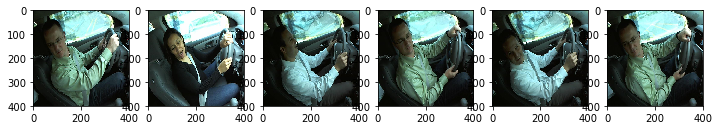

In [161]:
#print([val_imgs[i] for i in incorrect[:6]])
idxs = np.random.permutation(incorrect)
plots([val_imgs[i] for i in idxs[:6]])